## SQL INJECTION


In [1]:
import sklearn.feature_extraction
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# importando librerias de matplot 
import seaborn

In [2]:
# leyendo los datos desde los archivos 
import os
import csv
basedir = 'datasql'
filelist = os.listdir(basedir) 
df_csv = []
data=[]
for file in filelist:
    if file.split('.')[0] != 'yourfile':
        with open(os.path.join(basedir,file),encoding='utf8') as fp:
            for line in fp:
                data1 = []
                data1.append(line.rstrip("\n"))
                if file.split('.')[0] == 'legit':
                    data1.append('legitimo')
                else:
                    data1.append('malo')    
                df_csv.append(data1)
                
df1 = pd.DataFrame(df_csv,columns=['consulta_sql','tipo'])  
df1.to_csv(os.path.join(basedir,'yourfile.csv'), encoding='utf8',sep='|',index=False, header=True)
dataframe=pd.read_csv(os.path.join(basedir,'yourfile.csv'),encoding='utf-8',sep='|',header=0)   
dataframe['consulta_sql'].head(15)


0        '; exec master..xp_cmdshell 'ping 10.10.1.2'--
1              create user name identified by 'pass123'
2     create user name identified by pass123 tempora...
3                  exec sp_addlogin 'name' , 'password'
4          exec sp_addsrvrolemember 'name' , 'sysadmin'
5     insert into mysql.user (user, host, password) ...
6        grant connect to name; grant resource to name;
7     insert into users(login, password, level) valu...
8                        ALTER SYSTEM FLUSH SHARED_POOL
9     ALTER TABLE metadatacollectionschema.altidcoll...
10    ALTER TABLE metadatacollectionschema.andsactiv...
11    ALTER TABLE metadatacollectionschema.andsparty...
12    ALTER TABLE metadatacollectionschema.andsservi...
13    ALTER TABLE metadatacollectionschema.contribut...
14    ALTER TABLE metadatacollectionschema.custodian...
Name: consulta_sql, dtype: object

In [3]:
# clasificando las consultas de tipo o legitimo
dataframe.head(10)

consulta_sql      tipo
0     '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo
1           create user name identified by 'pass123'      malo
2  create user name identified by pass123 tempora...      malo
3               exec sp_addlogin 'name' , 'password'      malo
4       exec sp_addsrvrolemember 'name' , 'sysadmin'      malo
5  insert into mysql.user (user, host, password) ...      malo
6     grant connect to name; grant resource to name;      malo
7  insert into users(login, password, level) valu...      malo
8                     ALTER SYSTEM FLUSH SHARED_POOL  legitimo
9  ALTER TABLE metadatacollectionschema.altidcoll...  legitimo

In [4]:
# describe cuanto malos hay y cuantos legitimos y total
print(dataframe['tipo'].value_counts())
print("Total: %s" % sum(dataframe['tipo'].value_counts()))

malo        12893
legitimo     1003
Name: tipo, dtype: int64
Total: 13896


In [4]:
# Mostrando en forma grafica las consultas de tipo malo o legitimo
data_sql_injection = dataframe[['consulta_sql','tipo']]
seaborn.countplot(x='tipo',data=data_sql_injection)

c:\python35\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


In [5]:
# Se usa el modulo sqlparse para determinar las instrucciones de SQL, como select,union, etc. ademas de 
# veridicar los tipos ver en
# https://github.com/andialbrecht/sqlparse
import sqlparse
def parse_it(raw_sql):
    parsed = sqlparse.parse(str(raw_sql))
    x=[]
    for parse in parsed:
        for token in parse.tokens:
            if token._get_repr_name() != 'Whitespace':
                x.append(token._get_repr_name())
    return x
dataframe['parseando_sql'] = dataframe['consulta_sql'].map(lambda x: parse_it(x))


In [6]:
dataframe.head(10)


consulta_sql      tipo  \
0     '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo   
1           create user name identified by 'pass123'      malo   
2  create user name identified by pass123 tempora...      malo   
3               exec sp_addlogin 'name' , 'password'      malo   
4       exec sp_addsrvrolemember 'name' , 'sysadmin'      malo   
5  insert into mysql.user (user, host, password) ...      malo   
6     grant connect to name; grant resource to name;      malo   
7  insert into users(login, password, level) valu...      malo   
8                     ALTER SYSTEM FLUSH SHARED_POOL  legitimo   
9  ALTER TABLE metadatacollectionschema.altidcoll...  legitimo   

                                       parseando_sql  
0  [Single, Identifier, Float, Float, Float, Erro...  
1  [DDL, Keyword, Identifier, Keyword, Keyword, S...  
2  [DDL, Keyword, Identifier, Keyword, Keyword, I...  
3              [Keyword, Identifier, IdentifierList]  
4              [Keyword, Identifier, IdentifierList]  
5   [DML, Keyword, Identifier, Keyword, Parenthesis]  
6  [Keyword, Keyword, Keyword, Identifier, Punctu...  
7  [DML, Keyword, Function, Keyword, Punctuation,...  
8                [DDL, Keyword, Keyword, Identifier]  
9  [DDL, Keyword, Identifier, Keyword, Keyword, I...

In [7]:
def tri_gram(lst):
    ngrams = []
    ngrams +=zip(lst)
    ngrams += zip(lst,lst[1:]) #bi_gram
    ngrams += zip(lst,lst[1:],lst[2:]) #tri_gram
    return [str(tuple) for tuple in ngrams]

In [8]:
dataframe['secuencias'] = dataframe['parseando_sql'].map(lambda x: tri_gram(x))
for i in range(5):
    print('%+40s' % ("***** parseando sql ****"))
    print(dataframe['parseando_sql'][i],"\n")
    print("%+40s" % ("***** Secuencias ****"))
    print(dataframe['secuencias'][i])
    print("\n")

                ***** parseando sql ****
['Single', 'Identifier', 'Float', 'Float', 'Float', 'Error', 'Single'] 

                   ***** Secuencias ****
["('Single',)", "('Identifier',)", "('Float',)", "('Float',)", "('Float',)", "('Error',)", "('Single',)", "('Single', 'Identifier')", "('Identifier', 'Float')", "('Float', 'Float')", "('Float', 'Float')", "('Float', 'Error')", "('Error', 'Single')", "('Single', 'Identifier', 'Float')", "('Identifier', 'Float', 'Float')", "('Float', 'Float', 'Float')", "('Float', 'Float', 'Error')", "('Float', 'Error', 'Single')"]


                ***** parseando sql ****
['DDL', 'Keyword', 'Identifier', 'Keyword', 'Keyword', 'Single'] 

                   ***** Secuencias ****
["('DDL',)", "('Keyword',)", "('Identifier',)", "('Keyword',)", "('Keyword',)", "('Single',)", "('DDL', 'Keyword')", "('Keyword', 'Identifier')", "('Identifier', 'Keyword')", "('Keyword', 'Keyword')", "('Keyword', 'Single')", "('DDL', 'Keyword', 'Identifier')", "('Keyword', 'I

In [14]:
# metodo auxiliar
# proxima letra que se puede repetir
def token_expansion(series, types):
    _tokens, _types = zip(*[(token,token_type) for t_list,token_type in zip(series,types) for token in t_list])
    return pd.Series(_tokens), pd.Series(_types)

In [24]:
import simple_stats as ss
import csv
g_test = ss.GTest()
tokens, types = token_expansion(dataframe['secuencias'], dataframe['tipo'])
with open(os.path.join('resultados','token_expansion.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    for val_a,val_b in zip(tokens,types):
        writer.writerow([val_a,val_b])
df_ct, df_cd, df_stats = g_test.highest_gtest_scores(tokens, types, matches=0, N=0)
# import estados
df3 = pd.DataFrame(df_stats)  
df3.to_csv(os.path.join('resultados','df_stasts.csv'), encoding='utf8',sep='|',index=True,header=True)

In [12]:
# print(df_ct)
# print(df_cd)
df_stats.sort_values('malo_g', ascending=0).head(20)
# df_stats
# print(tokens)
# dataframe


legitimo     malo  legitimo_cd  \
('Single',)                                         6.0  10993.0     0.000546   
('Single', 'Identifier')                            0.0   8310.0     0.000000   
('Identifier',)                                  1273.0  16950.0     0.069857   
('Punctuation',)                                  152.0   7811.0     0.019088   
('Identifier', 'Single')                            1.0   4221.0     0.000237   
('Single', 'Identifier', 'Single')                  0.0   4170.0     0.000000   
('Identifier', 'Single', 'Identifier')              0.0   4162.0     0.000000   
('Identifier', 'Identifier')                        1.0   3956.0     0.000253   
('Keyword', 'DML', 'IdentifierList')               32.0   3157.0     0.010034   
('Punctuation', 'Punctuation')                      1.0   2858.0     0.000350   
('Punctuation', 'Keyword')                          1.0   2704.0     0.000370   
('Keyword', 'DML')                                105.0   3253.0     0.031269   
('Punctuation', 'Keyword', 'DML')                   0.0   2040.0     0.000000   
('Error',)                                          9.0   1919.0     0.004668   
('DML', 'IdentifierList', 'Single')                 0.0   1633.0     0.000000   
('IdentifierList', 'Single')                        0.0   1633.0     0.000000   
('DML', 'IdentifierList')                         266.0   3157.0     0.077710   
('Error', 'Keyword')                                2.0    997.0     0.002002   
('Punctuation', 'Punctuation', 'Keyword')           0.0    972.0     0.000000   
('Punctuation', 'Punctuation', 'Punctuation')       0.0    970.0     0.000000   

                                                malo_cd  total_cd  \
('Single',)                                    0.999454   10999.0   
('Single', 'Identifier')                       1.000000    8310.0   
('Identifier',)                                0.930143   18223.0   
('Punctuation',)                               0.980912    7963.0   
('Identifier', 'Single')                       0.999763    4222.0   
('Single', 'Identifier', 'Single')             1.000000    4170.0   
('Identifier', 'Single', 'Identifier')         1.000000    4162.0   
('Identifier', 'Identifier')                   0.999747    3957.0   
('Keyword', 'DML', 'IdentifierList')           0.989966    3189.0   
('Punctuation', 'Punctuation')                 0.999650    2859.0   
('Punctuation', 'Keyword')                     0.999630    2705.0   
('Keyword', 'DML')                             0.968731    3358.0   
('Punctuation', 'Keyword', 'DML')              1.000000    2040.0   
('Error',)                                     0.995332    1928.0   
('DML', 'IdentifierList', 'Single')            1.000000    1633.0   
('IdentifierList', 'Single')                   1.000000    1633.0   
('DML', 'IdentifierList')                      0.922290    3423.0   
('Error', 'Keyword')                           0.997998     999.0   
('Punctuation', 'Punctuation', 'Keyword')      1.000000     972.0   
('Punctuation', 'Punctuation', 'Punctuation')  1.000000     970.0   

                                               legitimo_exp   legitimo_g  \
('Single',)                                     1239.789728   -63.971251   
('Single', 'Identifier')                         936.689939     0.000000   
('Identifier',)                                 2054.067480 -1218.122610   
('Punctuation',)                                 897.576653  -539.848673   
('Identifier', 'Single')                         475.897103   -12.330403   
('Single', 'Identifier', 'Single')               470.035745     0.000000   
('Identifier', 'Single', 'Identifier')           469.133998     0.000000   
('Identifier', 'Identifier')                     446.026725   -12.200758   
('Keyword', 'DML', 'IdentifierList')             359.458991  -154.807309   
('Punctuation', 'Punctuation')                   322.261918   -11.550729   
('Punctuation', 'Keyword')                       304.903283

In [13]:
dataframe[dataframe['secuencias'].map(lambda x: "('Single', 'Identifier')" in x)].head()

consulta_sql  tipo  \
0        '; exec master..xp_cmdshell 'ping 10.10.1.2'--  malo   
1033                                anything' or 'x'='x  malo   
1038  '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....  malo   
1043  '; if not(select system_user) <> 'sa' waitfor ...  malo   
1044  '; if is_srvrolemember('sysadmin') > 0 waitfor...  malo   

                                          parseando_sql  \
0     [Single, Identifier, Float, Float, Float, Erro...   
1033  [Identifier, Single, Identifier, Single, Ident...   
1038                [Single, Identifier, Error, Single]   
1043  [Single, Identifier, Single, Integer, Punctuat...   
1044  [Single, Identifier, Single, Integer, Punctuat...   

                                             secuencias  
0     [('Single',), ('Identifier',), ('Float',), ('F...  
1033  [('Identifier',), ('Single',), ('Identifier',)...  
1038  [('Single',), ('Identifier',), ('Error',), ('S...  
1043  [('Single',), ('Identifier',), ('Single',), ('...  
1044  [('Single',), ('Identifier',), ('Single',), ('...

In [14]:
dataframe[dataframe['secuencias'].map(lambda x: "('Punctuation',)" in x)].head()

consulta_sql      tipo  \
2   create user name identified by pass123 tempora...      malo   
6      grant connect to name; grant resource to name;      malo   
7   insert into users(login, password, level) valu...      malo   
46  CREATE FUNCTION sylph.add_article(char, char, ...  legitimo   
47  CREATE FUNCTION sylph.add_comment(integer, cha...  legitimo   

                                        parseando_sql  \
2   [DDL, Keyword, Identifier, Keyword, Keyword, I...   
6   [Keyword, Keyword, Keyword, Identifier, Punctu...   
7   [DML, Keyword, Function, Keyword, Punctuation,...   
46  [DDL, Keyword, Identifier, Keyword, Identifier...   
47  [DDL, Keyword, Identifier, Keyword, Identifier...   

                                           secuencias  
2   [('DDL',), ('Keyword',), ('Identifier',), ('Ke...  
6   [('Keyword',), ('Keyword',), ('Keyword',), ('I...  
7   [('DML',), ('Keyword',), ('Function',), ('Keyw...  
46  [('DDL',), ('Keyword',), ('Identifier',), ('Ke...  
47  [('DDL',), ('Keyword',), ('Identifier',), ('Ke...

In [15]:
import numpy as np
def g_aggregate(sequence, name):
    try:
#         g_scores = [df_stats.ix[item][name] for item in sequence]
        g_scores = [df_stats.loc[item][name] for item in sequence]
    except KeyError:
        return 0
    return sum(g_scores)/len(g_scores) if g_scores else 0

dataframe['malo_g'] = dataframe['secuencias'].map(lambda x: g_aggregate(x, 'malo_g'))
dataframe['legitimo_g'] = dataframe['secuencias'].map(lambda x: g_aggregate(x, 'legitimo_g'))

In [16]:
dataframe.head(10)

consulta_sql      tipo  \
0     '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo   
1           create user name identified by 'pass123'      malo   
2  create user name identified by pass123 tempora...      malo   
3               exec sp_addlogin 'name' , 'password'      malo   
4       exec sp_addsrvrolemember 'name' , 'sysadmin'      malo   
5  insert into mysql.user (user, host, password) ...      malo   
6     grant connect to name; grant resource to name;      malo   
7  insert into users(login, password, level) valu...      malo   
8                     ALTER SYSTEM FLUSH SHARED_POOL  legitimo   
9  ALTER TABLE metadatacollectionschema.altidcoll...  legitimo   

                                       parseando_sql  \
0  [Single, Identifier, Float, Float, Float, Erro...   
1  [DDL, Keyword, Identifier, Keyword, Keyword, S...   
2  [DDL, Keyword, Identifier, Keyword, Keyword, I...   
3              [Keyword, Identifier, IdentifierList]   
4              [Keyword, Identifier, IdentifierList]   
5   [DML, Keyword, Identifier, Keyword, Parenthesis]   
6  [Keyword, Keyword, Keyword, Identifier, Punctu...   
7  [DML, Keyword, Function, Keyword, Punctuation,...   
8                [DDL, Keyword, Keyword, Identifier]   
9  [DDL, Keyword, Identifier, Keyword, Keyword, I...   

                                          secuencias      malo_g   legitimo_g  
0  [('Single',), ('Identifier',), ('Float',), ('F...  515.949283   -77.965546  
1  [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -358.303284  1518.503577  
2  [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -536.343845  1762.303762  
3  [('Keyword',), ('Identifier',), ('IdentifierLi... -301.271597  1213.043792  
4  [('Keyword',), ('Identifier',), ('IdentifierLi... -301.271597  1213.043792  
5  [('DML',), ('Keyword',), ('Identifier',), ('Ke... -490.814818  1587.229939  
6  [('Keyword',), ('Keyword',), ('Keyword',), ('I... -405.286025  1456.931839  
7  [('DML',), ('Keyword',), ('Function',), ('Keyw... -299.199687   763.308377  
8  [('DDL',), ('Keyword',), ('Keyword',), ('Ident... -540.614866  1646.406430  
9  [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -491.521983  1795.397911

In [17]:
dataframe[dataframe['secuencias'].map(lambda x: "('Single', 'Identifier')" in x)].head(10)

consulta_sql  tipo  \
0        '; exec master..xp_cmdshell 'ping 10.10.1.2'--  malo   
1033                                anything' or 'x'='x  malo   
1038  '; exec master..xp_cmdshell 'ping aaa.bbb.ccc....  malo   
1043  '; if not(select system_user) <> 'sa' waitfor ...  malo   
1044  '; if is_srvrolemember('sysadmin') > 0 waitfor...  malo   
1045  '; if not((select serverproperty('isintegrated...  malo   
1046  '; if not((select serverproperty('isintegrated...  malo   
1077                                        ' or 'a'='a  malo   
1079                                      ') or ('a'='a  malo   
1089                         ' or 'unusual' = 'unusual'  malo   

                                          parseando_sql  \
0     [Single, Identifier, Float, Float, Float, Erro...   
1033  [Identifier, Single, Identifier, Single, Ident...   
1038                [Single, Identifier, Error, Single]   
1043  [Single, Identifier, Single, Integer, Punctuat...   
1044  [Single, Identifier, Single, Integer, Punctuat...   
1045  [Single, Identifier, Single, Integer, Punctuat...   
1046  [Single, Identifier, Single, Integer, Punctuat...   
1077           [Single, Identifier, Single, Identifier]   
1079           [Single, Identifier, Single, Identifier]   
1089    [Single, Identifier, Single, Identifier, Error]   

                                             secuencias       malo_g  \
0     [('Single',), ('Identifier',), ('Float',), ('F...   515.949283   
1033  [('Identifier',), ('Single',), ('Identifier',)...  1584.285213   
1038  [('Single',), ('Identifier',), ('Error',), ('S...  1029.796858   
1043  [('Single',), ('Identifier',), ('Single',), ('...   650.445459   
1044  [('Single',), ('Identifier',), ('Single',), ('...   650.445459   
1045  [('Single',), ('Identifier',), ('Single',), ('...   650.445459   
1046  [('Single',), ('Identifier',), ('Single',), ('...   650.445459   
1077  [('Single',), ('Identifier',), ('Single',), ('...  1712.117299   
1079  [('Single',), ('Identifier',), ('Single',), ('...  1712.117299   
1089  [('Single',), ('Identifier',), ('Single',), ('...  1320.819695   

      legitimo_g  
0     -77.965546  
1033 -317.247595  
1038 -155.246815  
1043  -99.593613  
1044  -99.593613  
1045  -99.593613  
1046  -99.593613  
1077 -286.279792  
1079 -286.279792  
1089 -218.972862

In [18]:
dataframe[dataframe['secuencias'].map(lambda x: "('Punctuation',)" in x)].head()

consulta_sql      tipo  \
2   create user name identified by pass123 tempora...      malo   
6      grant connect to name; grant resource to name;      malo   
7   insert into users(login, password, level) valu...      malo   
46  CREATE FUNCTION sylph.add_article(char, char, ...  legitimo   
47  CREATE FUNCTION sylph.add_comment(integer, cha...  legitimo   

                                        parseando_sql  \
2   [DDL, Keyword, Identifier, Keyword, Keyword, I...   
6   [Keyword, Keyword, Keyword, Identifier, Punctu...   
7   [DML, Keyword, Function, Keyword, Punctuation,...   
46  [DDL, Keyword, Identifier, Keyword, Identifier...   
47  [DDL, Keyword, Identifier, Keyword, Identifier...   

                                           secuencias      malo_g   legitimo_g  
2   [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -536.343845  1762.303762  
6   [('Keyword',), ('Keyword',), ('Keyword',), ('I... -405.286025  1456.931839  
7   [('DML',), ('Keyword',), ('Function',), ('Keyw... -299.199687   763.308377  
46  [('DDL',), ('Keyword',), ('Identifier',), ('Ke...  -41.906355   820.869116  
47  [('DDL',), ('Keyword',), ('Identifier',), ('Ke...  -39.227730   815.670087

In [19]:
import math
from collections import Counter
def entropy(s):
    p = Counter(s)
    lns = len(s)
    suma = 0.0
    for count in p.values():
        suma = suma - (count/float(lns)*math.log(count/float(lns), 2))
    return suma
dataframe['longitud'] = dataframe['parseando_sql'].map(lambda x: len(x))
dataframe['entropia'] = dataframe['consulta_sql'].map(lambda x: entropy(x))
#importando a un csv
dataframe.to_csv(os.path.join('resultados','sql_random_data.csv'), encoding='utf8',sep='|',index=False,header=True)
dataframe.head(10)

consulta_sql      tipo  \
0     '; exec master..xp_cmdshell 'ping 10.10.1.2'--      malo   
1           create user name identified by 'pass123'      malo   
2  create user name identified by pass123 tempora...      malo   
3               exec sp_addlogin 'name' , 'password'      malo   
4       exec sp_addsrvrolemember 'name' , 'sysadmin'      malo   
5  insert into mysql.user (user, host, password) ...      malo   
6     grant connect to name; grant resource to name;      malo   
7  insert into users(login, password, level) valu...      malo   
8                     ALTER SYSTEM FLUSH SHARED_POOL  legitimo   
9  ALTER TABLE metadatacollectionschema.altidcoll...  legitimo   

                                       parseando_sql  \
0  [Single, Identifier, Float, Float, Float, Erro...   
1  [DDL, Keyword, Identifier, Keyword, Keyword, S...   
2  [DDL, Keyword, Identifier, Keyword, Keyword, I...   
3              [Keyword, Identifier, IdentifierList]   
4              [Keyword, Identifier, IdentifierList]   
5   [DML, Keyword, Identifier, Keyword, Parenthesis]   
6  [Keyword, Keyword, Keyword, Identifier, Punctu...   
7  [DML, Keyword, Function, Keyword, Punctuation,...   
8                [DDL, Keyword, Keyword, Identifier]   
9  [DDL, Keyword, Identifier, Keyword, Keyword, I...   

                                          secuencias      malo_g   legitimo_g  \
0  [('Single',), ('Identifier',), ('Float',), ('F...  515.949283   -77.965546   
1  [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -358.303284  1518.503577   
2  [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -536.343845  1762.303762   
3  [('Keyword',), ('Identifier',), ('IdentifierLi... -301.271597  1213.043792   
4  [('Keyword',), ('Identifier',), ('IdentifierLi... -301.271597  1213.043792   
5  [('DML',), ('Keyword',), ('Identifier',), ('Ke... -490.814818  1587.229939   
6  [('Keyword',), ('Keyword',), ('Keyword',), ('I... -405.286025  1456.931839   
7  [('DML',), ('Keyword',), ('Function',), ('Keyw... -299.199687   763.308377   
8  [('DDL',), ('Keyword',), ('Keyword',), ('Ident... -540.614866  1646.406430   
9  [('DDL',), ('Keyword',), ('Identifier',), ('Ke... -491.521983  1795.397911   

   longitud  entropia  
0         7  4.368792  
1         6  4.037326  
2        13  4.017044  
3         3  4.030493  
4         3  4.010013  
5         5  4.420823  
6        10  3.498879  
7         6  4.387660  
8         4  3.831402  
9         6  4.402039

In [20]:
X = dataframe.as_matrix(['longitud', 'entropia','legitimo_g','malo_g'])
y = np.array(dataframe['tipo'].tolist())  
# guardar la matriz de resultados
dfr = pd.DataFrame(dataframe.as_matrix(['longitud', 'entropia','legitimo_g','malo_g','tipo']),
                   columns=['longitud', 'entropia','legitimo_g','malo_g','tipo'])  
dfr.to_csv(os.path.join('resultados','random_fores_values.csv'), encoding='utf8',sep='|',index=False,header=True)

c:\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [21]:
# print(X)
# print(X[100])
# print(y)

In [22]:
import sklearn.ensemble
from  sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) 
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20,criterion='entropy')
print(clf)
print(train_test_split)
print(cross_val_score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
<function train_test_split at 0x0000002FB06AD510>
<function cross_val_score at 0x0000002FB06AD7B8>


In [23]:
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, dataframe.index, test_size=0.2)
# clf=clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [24]:
# importancias de cmapo
# print(list(clf.feature_importances_))
feature_choice=['malo_g','legitimo_g','longitud','entropia']
for feature, score in zip(feature_choice, list(clf.feature_importances_)):
    print ('%-15s %4f' %(feature, score))

malo_g          0.045750
legitimo_g      0.095748
longitud        0.571546
entropia        0.286956


In [25]:
# import el modelo para la aplicacion
filename = 'model_v1.pkl'
from sklearn.externals import joblib
joblib.dump(clf,os.path.join('resultados',filename))

['resultados\\model_v1.pkl']

In [26]:
# prediction to model
y_pred = clf.predict(X_test)
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred)*100)

99.6762589928


In [27]:
# calculando matriz de confucion
print("total test: %s" % len(y_test))
print("total entrenamiento: %s" %len(y_train))
print(metrics.confusion_matrix(y_test, y_pred))

total test: 2780
total entrenamiento: 11116
[[ 222    6]
 [   3 2549]]


In [28]:
# save confusion matrix and slice into four pieces
# **True Positives (TP)
# **True Negatives (TN)
# **False Positives (FP)
# **False Negatives (FN)
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("TP: %s" % TP)
print("TN: %s" % TN)
print("FP: %s" % FP)
print("FN: %s" % FN)

TP: 2549
TN: 222
FP: 6
FN: 3


In [29]:
# Exactitud de clasificacion Accuracy:** En general con que frecuencia es correcto el clasificador?
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred))

0.996762589928
0.996762589928


In [30]:
# Error de la clasificación: ¿** En general, con qué frecuencia es incorrecto el clasificador?
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred))

0.00323741007194
0.00323741007194


In [31]:
# Sensitivity:** When the actual value is positive, how often is the prediction correct?

# How "sensitive" is the classifier to detecting positive instances?
# Also known as "True Positive Rate" or "Recall"
print(TP / float(TP + FN))
# print(metrics.recall_score(y_test, y_pred))

0.998824451411


In [ ]:
# Specificity:** When the actual value is negative, how often is the prediction correct?

# How "specific" (or "selective") is the classifier in predicting positive instances?
print(TN / float(TN + FP))

In [33]:
# False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?
print(FP / float(TN + FP))

0.0218579234973


In [34]:
#Precision:** When a positive value is predicted, how often is the prediction correct?

# How "precise" is the classifier when predicting positive instances?
print(TP / float(TP + FP))
# print(metrics.precision_score(y_test, y_pred))

0.998460354119


In [35]:
test_set = dataframe.ix[index_test]
test_set
test_set['pred'] = y_pred
misclassified = test_set[(test_set['tipo']=='legitimo') & (test_set['pred']=='malo')]
misclassified.head(100)

c:\python35\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


consulta_sql      tipo  \
849  leads := select E.eID from employee E where ex...  legitimo   
443                                 SELECT * FROM S,SP  legitimo   
506  SELECT DAYOFMONTH(VARCHAR('2000-01-01'))/DAYOF...  legitimo   
852               numEmpsTakenArea := select * from g2  legitimo   

                                         parseando_sql  \
849  [Identifier, Assignment, DML, Identifier, Keyw...   
443           [DML, Wildcard, Keyword, IdentifierList]   
506   [DML, Operation, Keyword, IdentifierList, Where]   
852  [Identifier, Assignment, DML, Wildcard, Keywor...   

                                            secuencias      malo_g  \
849  [('Identifier',), ('Assignment',), ('DML',), (...    3.816616   
443  [('DML',), ('Wildcard',), ('Keyword',), ('Iden... -356.347436   
506  [('DML',), ('Operation',), ('Keyword',), ('Ide... -260.210679   
852  [('Identifier',), ('Assignment',), ('DML',), (...  -57.080834   

     legitimo_g  longitud  entropia  pred  
849  716.824030         7  4.389106  malo  
443  743.401415         4  3.530493  malo  
506  640.642017         5  4.656326  malo  
852  564.050771         6  4.270910  malo

In [36]:
def test_examples(sql):
    parsed_sql = parse_it(sql)
    ngram_list = tri_gram(parsed_sql)
    malicious_g = g_aggregate(ngram_list, 'malo_g')
    legit_g = g_aggregate(ngram_list, 'legitimo_g')
    _X = [len(parsed_sql), entropy(sql), legit_g, malicious_g]
    _Y=clf.predict([_X])
    print ('%-40s: %s' % (sql, _Y))

In [37]:
test_examples('select * from employees')
test_examples("'; exec master..xp_cmdshell")
test_examples("'any 'x'='x'")
test_examples('from dorseys mom xp_cmdshell biache')
test_examples('select * from your_mom')
test_examples("1 or 1=1")
test_examples("1 or 1=1--")
test_examples("' or username like char(37)") # male

select * from employees                 : ['legitimo']
'; exec master..xp_cmdshell             : ['malo']
'any 'x'='x'                            : ['malo']
from dorseys mom xp_cmdshell biache     : ['malo']
select * from your_mom                  : ['legitimo']
1 or 1=1                                : ['malo']
1 or 1=1--                              : ['malo']
' or username like char(37)             : ['malo']


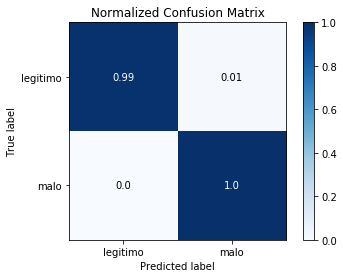

In [47]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [48]:
# graficando el aprendizaje de curva

scikitplot.estimators.plot_learning_curve(clf,X_train,y_train)

In [49]:
#confusion matriz segun scikitplot
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred)

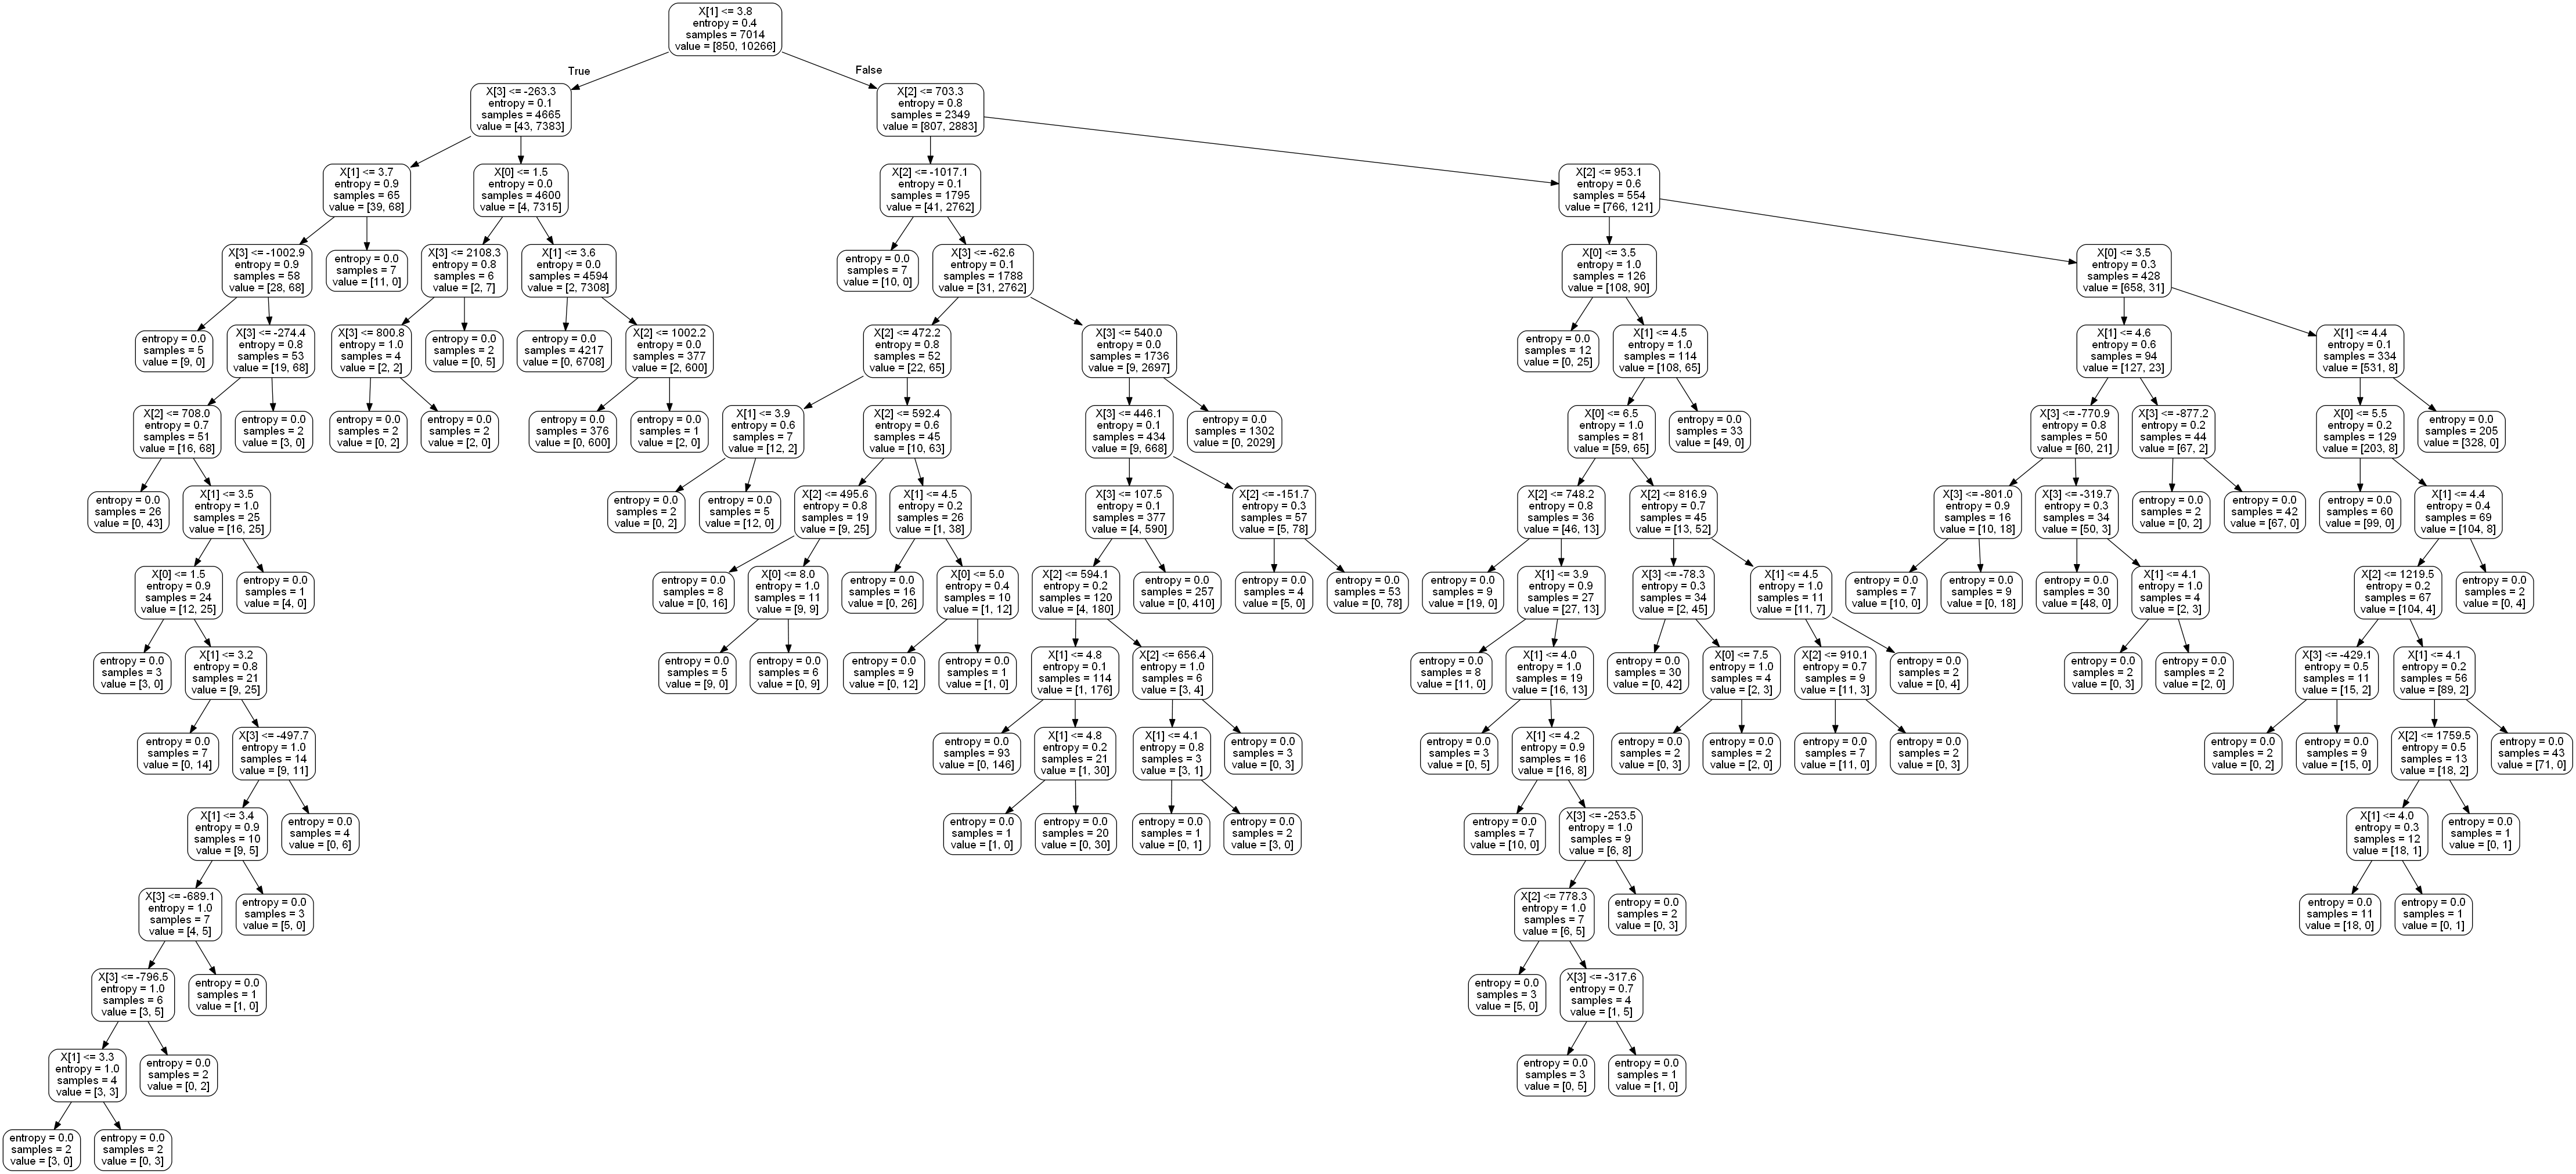

In [50]:
# graficando
import graphviz
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(clf.estimators_[5], out_file=dot_data,rounded = True,precision=1)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())